# Heim & Kratzer Chapter 4

This notebook demonstrates the Heim & Kratzer (1998) Chapter 4 semantic rules using a toy lexicon, the `Interpreter` class, and the ultra-light backtick DSL for `PhiValue` literals.

## Import Required Libraries

Import all necessary modules, including `Interpreter`, `Tree`, `PhiValue`, and the backtick DSL installer.

In [1]:
# Install phosphorus if necessary
try:
  import p4s
except ImportError:
  %pip install p4s


             _    _                  _    _
            | |  | |                | |  | |
           _| |_ | |__   ___  ___  _| |_ | |__   ___  _ __ _   _  ____
          /     \| '_ \ / _ \/ __|/     \| '_ \ / _ \| '__| | | |/ ___)
         ( (| |) ) | | | (_) \__ ( (| |) ) | | | (_) | |  | |_| ( (__
          \_   _/|_| |_|\___/|___/\_   _/|_| |_|\___/|_|   \__,_|\__ \
            | |                     | |                            _) )
            |_|                     |_|                           (__/

        Welcome to the Phosphorus Meaning Engine v4
        Created by Ezra Keshet (EzraKeshet.com)




In [2]:
# Import code from p4s
from p4s import *

# Configure IPython to display all outputs in a cell
%config InteractiveShell.ast_node_interactivity='all'
from IPython.display import Markdown

In [3]:
def singular(f):
  if hasattr(f, 'stype') and f.stype != Type.et:
    return False
  # A predicate is singular if it returns True for exactly one entity
  return sum(f(x) for x in DOMAIN) == 1

In [4]:
Markdown('###Single dog')
the = phi[lambda f: iota(f) % singular(f) :: et_e]
#dog = phi[lambda x: x in 'A' :: et]
dog = phi[lambda x: x == 'A' :: et]
charset(dog)
the(dog)

Markdown('###Multiple dogs')
dog = phi[lambda x: x in list('ABCDE') :: et]
charset(dog)
the(dog)

###Single dog

{'A'}

'A'

###Multiple dogs

{'A', 'B', 'C', 'D', 'E'}

## Define Lexicon

Create a dictionary mapping lexical items (e.g., 'john', 'mary', 'runs', 'loves') to their `PhiValue` representations using the backtick DSL.

In [5]:
lexicon = {
  "john"  : `JOHN.e,
  "mary"  : `MARY.e,
  "cat"   : `lambda x=e: CAT(x).t,
  "gray"  : `lambda x=e: GRAY(x).t,
  "runs"  : `lambda x=e: RUN(x).t,
  "loves" : `lambda y=e: (lambda x=e: LOVE(x,y).t),
  "the"   : `lambda f=et: iota(f).e % singular(f),
}

## Create Interpreter and Register Rules

Instantiate an `Interpreter` named `interpret4`, assign the lexicon, and define the TN, NN, FA, and PM rules.

In [6]:
interpret4 = Interpreter(lexicon=lexicon)

# Terminal Node (TN): lexical lookup
@interpret4.rule()
def TN(*, alpha: str):    
  """Terminal Node: lexical lookup of *alpha* (string token)."""
  return interpret4.lookup(alpha)

# Non-Branching Node (NN): pass child meaning unchanged
@interpret4.rule()
def NN(beta: PhiValue):
  """Non-branching Node: pass child meaning unchanged."""
  return beta

# Functional Application (FA): apply function to argument
@interpret4.rule()
def FA(beta: PhiValue, gamma: PhiValue):
  """Functional Application (order determined by `takes`)."""
  if UNDEF in (beta, gamma):
    return UNDEF

  if takes(beta, gamma):
    fn, arg = beta, gamma
  elif takes(gamma, beta):
    fn, arg = gamma, beta
  else:
    return UNDEF

  return `fn(arg) % defined(arg) # Note that if arg fails the fn guard, it will already return UNDEF

# Predicate Modification (PM): conjoin meanings
@interpret4.rule()
def PM(beta: PhiValue, gamma: PhiValue):
  """Predicate Modification: conjoin meanings."""
  if UNDEF in (beta, gamma):
    return UNDEF
  
  if beta.stype == gamma.stype == Type.et:
    return `lambda x=e: beta(x) and gamma(x) % defined(beta(x)) % defined(gamma(x))

  return UNDEF

In [7]:
lexicon["gray"]

lambda x: GRAY(x)

## Test Example Sentences

Parse and interpret example syntactic trees using `interpret4`, displaying both the tree and its semantic interpretation.

In [8]:
examples = [
  '(NP gray cat)',
  '(NP the cat)',
  '(S (NP the cat) (VP runs))',
  '(S (NP the cat) (VP (V loves) (NP Mary)))',
  '(DP the (NP gray cat))',
  '(S (DP the (NP gray cat)) (VP (V loves) (DP Mary)))',
]

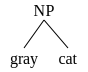

NPgraycat,<UNDEF>


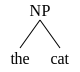

NPthecat,<UNDEF>


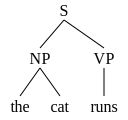

SNPthecatVPruns,<UNDEF>


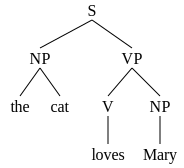

SNPthecatVPVlovesNPMary,<UNDEF>


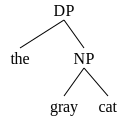

DPtheNPgraycat,<UNDEF>


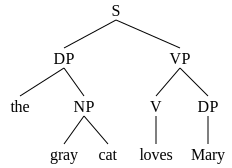

SDPtheNPgraycatVPVlovesDPMary,<UNDEF>


In [9]:
from IPython.display import display, HTML

for src in examples:
  tree = Tree.fromstring(src)
  meaning = interpret4.interpret(tree)
  tree_html = tree._repr_svg_()  # SVG as HTML string
  meaning_html = meaning._repr_html_()  # HTML as string
  display(HTML(f"""
    <table>
      <tr>
        <td style="vertical-align:top;min-width:18ch;text-align:left">{tree_html}</td>
        <td style="vertical-align:top;padding-left:2em">{meaning_html}</td>
      </tr>
    </table>
  """))

In [10]:
DOMAIN = [PhiValue(x, stype=Type.e) for x in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']  # Example domain of entities
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z = DOMAIN

def singular(f: PhiValue) -> bool:
  """Check if the predicate f is singular."""
  if f.stype != Type.et:
    return False
  # A predicate is singular if it returns True for exactly one entity
  count = sum(1 for x in DOMAIN if f(x))
  return count == 1

def CAT(x): 
  return x == PhiValue('A')

CAT(A), CAT(B)
lexicon["cat"](A), lexicon["cat"](B)

f'{singular(lexicon["cat"])=}'


(True, False)

(1, 0)

'singular (lexicon ["cat"])=True'